In [1]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from math import pi
from scipy.linalg import expm
from scipy.optimize import minimize

In [2]:
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])
sigmap = np.array([[0,1],[0,0]])
sigmam = np.array([[0,0],[1,0]])

def String(num_string):
    SOP = 1
    for ns, sid in enumerate(num_string):
        if sid == 0:
            OP = np.eye(2)
        elif sid==1:
            OP = sigmax
        elif sid==2:
            OP = sigmay
        elif sid==3:
            OP = sigmaz
        elif sid == 4:
            OP = sigmam
        elif sid == 5:
            OP = sigmap
        else:
            pass
        SOP = np.kron(OP,SOP)
    return SOP

def qtoclabel(num_string):
    stat_num = 0
    for ns, sid in enumerate(num_string):
        stat_num = stat_num + sid*(2**ns)
    return stat_num

def qubit_state(Num,ind):
    t0 = ind
    d = np.zeros(Num)
    for n in range(Num-1,0,-1):
        d[n] = np.int_(np.floor(t0/(2**n)))
        t0 = t0 - d[n]*2**n
    d[0] = np.remainder(ind,2)
    return d

In [3]:
### single-exciation terms are represented by an array with two elements with the first one denoting creation operaotr localtion
### and the second one for the annihilation location
def generate_Pstring(array,N):
    if array[0]!=array[1]:
        M = np.zeros([1,N],dtype=int)
        M[0,array[0]] = 4
        M[0,array[1]] = 5
        for n in range(np.min(array)+1,np.max(array),1):
            M[0,n] = 3
        sgn = np.array([1])
    else:
        M = np.zeros((2,N),dtype=int)
        M[1,array[0]]=3
        sgn = np.array([1/2,-1/2])
    return M, sgn

def generate_matrix_from_CA(array,N):
    ## here the even index of array is for the location of creation operator, and odd index for the annihilation operator
    L = len(array)
    Ne = np.int(L/2) # number of exciations
    ### get Pauli string arrays
    Pstr=[]
    Sgn_arr = []
    for n in range(Ne):
        A, B = generate_Pstring(np.array([array[2*n],array[2*n+1]]),N)
        Pstr.append(A)
        Sgn_arr.append(B)
    H1e = np.eye(2**N,2**N);
    for n in range(Ne):
        A = np.zeros((2**N,2**N),dtype=complex)
        for n1 in range(len(Sgn_arr[n])):
            A = A + String(Pstr[n][n1,:])*Sgn_arr[n][n1]
        H1e = np.dot(H1e,A)
    return H1e

In [4]:
def get_Ham_tot(t,kx,ky,array,N):
    Hop = np.zeros((2**N,2**N),dtype=complex)
    coef = np.array([-t,-t,-t*np.cos(3*kx),1j*t*np.sin(3*kx),-t,-t,-t*np.cos(3*kx),-1j*t*np.sin(3*kx), \
                     -2*t*np.cos(ky),-2*t*np.cos(ky+2*pi/3),-2*t*np.cos(ky+4*pi/3)])
    for n in range(len(coef)):
        Hop = Hop + generate_matrix_from_CA(array[n,:],N)*coef[n]
    return Hop

In [5]:
def find_min_half(psi,Eng):
    on1 = (String(np.array([0,0,0])) - String(np.array([3,0,0])))/2
    on2 = (String(np.array([0,0,0])) - String(np.array([0,3,0])))/2
    on3 = (String(np.array([0,0,0])) - String(np.array([0,0,3])))/2
    half_state = np.array([],dtype=int)
    for n in range(len(Eng)):
        if np.allclose(np.dot(psi[:,n].conj().T,np.dot(on1+on2+on3,psi[:,n])),2):
            half_state = np.append(half_state,np.int(n))
    return half_state

In [6]:
## CA string for the bulk x hopping
arrayhop_f = np.array([[0,1],[1,2],[0,2],[0,2]])
arrayhop_b = np.array([[1,0],[2,1],[2,0],[2,0]])

array_hop = np.vstack((arrayhop_f,arrayhop_b))

## CA string for the on-site potential
array_on = np.array([[0,0],[1,1],[2,2]])

array_tot = np.vstack((array_hop,array_on))

In [7]:
def build_opt(vec1,vec2):
    in_product = np.dot(vec1.conj().T,vec2)

    U = in_product / np.abs(in_product)

    return U

def Xlink(t,Dkx,kx,ky,array):
    Nx = len(kx)
    Ny = len(ky)
    Ux = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            Hmol = get_Ham_tot(t,kx[nx],ky[ny],array,3)
            # initial basis
            Emany, Vmany = np.linalg.eig(Hmol)
            idx = Emany.argsort()[::+1]
            Eng = Emany[idx]
            WF = Vmany[:,idx]
            psi = WF[:,find_min_half(WF,Eng)[0]]
            ############
            Hmol = get_Ham_tot(t,kx[nx]+Dkx,ky[ny],array,3)
            Emany, Vmany = np.linalg.eig(Hmol)
            idx = Emany.argsort()[::+1]
            Eng = Emany[idx]
            WF = Vmany[:,idx]
            psiDx = WF[:,find_min_half(WF,Eng)[0]]
            Ux[nx*Ny+ny] = build_opt(psiDx, psi )
    return Ux

def Ylink(t,Dky,kx,ky,array):
    Nx = len(kx)
    Ny = len(ky)
    Uy = np.zeros((Nx*Ny),complex)
    for nx in range(Nx):
        for ny in range(Ny):
            Hmol = get_Ham_tot(t,kx[nx],ky[ny],array,3)
            # initial basis
            Emany, Vmany = np.linalg.eig(Hmol)
            idx = Emany.argsort()[::+1]
            Eng = Emany[idx]
            WF = Vmany[:,idx]
            psi = WF[:,find_min_half(WF,Eng)[0]]
            ############
            # many-body Hamiltonian
            Hmol = get_Ham_tot(t,kx[nx],ky[ny]+Dky,array,3)
            Emany, Vmany = np.linalg.eig(Hmol)
            idx = Emany.argsort()[::+1]
            Eng = Emany[idx]
            WF = Vmany[:,idx]
            psiDy = WF[:,find_min_half(WF,Eng)[0]]
            Uy[nx*Ny+ny] = build_opt(psiDy, psi )
    return Uy

In [8]:
def get_Chern(kx,ky,Ux,Uy):
    sumNc = 0
    Nx = len(kx)
    Ny = len(ky)
    for nx in range(len(kx)):
        for ny in range(len(ky)):
            U1x = Ux[nx*Ny+ny]
            U2y = Uy[nx*Ny+ny]
            if ny+1==Ny:
                U1y = Ux[nx*Ny]
            else:
                U1y = Ux[nx*Ny+(ny+1)]
            if nx+1==Nx:
                U2x = Uy[ny]
            else:
                U2x = Uy[(nx+1)*Ny+ny]
            LF = np.log( U1x * U2x * 1./U1y * 1./U2y)
            sumNc += LF
    chernN = sumNc.imag/(2.*np.pi)
    return chernN

In [9]:
Nx = 3
Ny = 8

kx = np.arange(0,Nx,1)*(2*pi/3)/Nx
ky = np.arange(0,Ny,1)*2*pi/Ny+0.1

Dkx = ((2.*pi)/3)/Nx
Dky = (2.*pi)/Ny

Ux = Xlink(1,Dkx,kx,ky,array_tot)
Uy = Ylink(1,Dky,kx,ky,array_tot)

In [10]:
Ux

array([0.99780532-0.06621586j, 0.99999476-0.00323846j,
       0.99975594+0.02209213j, 0.99986232-0.01659348j,
       0.99876421+0.04969953j, 0.8569963 +0.51532256j,
       0.99472565-0.10257136j, 0.99988596-0.01510193j,
       0.99664862+0.0818018j , 0.99998578+0.00533256j,
       0.99946774-0.03262264j, 0.98492607+0.17297582j,
       0.98761274+0.15691106j, 0.81819442+0.57494165j,
       0.9732578 -0.22971559j, 0.98999688-0.14108925j,
       0.99780532-0.06621586j, 0.99999476-0.00323846j,
       0.99975594+0.02209213j, 0.99986232-0.01659348j,
       0.99876421+0.04969953j, 0.8569963 +0.51532256j,
       0.99472565-0.10257136j, 0.99988596-0.01510193j])

In [11]:
Uy

array([ 1.        +0.j        ,  1.        +0.j        ,
        1.        +0.j        ,  1.        +0.j        ,
        1.        +0.j        , -1.        +0.j        ,
        1.        +0.j        ,  1.        +0.j        ,
        0.99981283-0.01934673j,  0.99987242-0.01597297j,
        0.98010841-0.19846284j,  0.99986494-0.01643503j,
        0.99982775-0.01855983j,  0.66111613+0.75028359j,
        0.99988421-0.01521751j,  0.98044475-0.19679453j,
        0.99981283+0.01934673j,  0.99987242+0.01597297j,
        0.98010841+0.19846284j,  0.99986494+0.01643503j,
        0.99982775+0.01855983j,  0.66111613-0.75028359j,
        0.99988421+0.01521751j,  0.98044475+0.19679453j])

In [12]:
Nx = len(kx)
Ny = len(ky)
LF = np.zeros(24,dtype=complex)
LF1 = np.zeros(24,dtype=complex)
for nx in range(len(kx)):
    for ny in range(len(ky)):
        U1x = Ux[nx*Ny+ny]
        U2y = Uy[nx*Ny+ny]
        if ny+1==Ny:
            U1y = Ux[nx*Ny]
        else:
            U1y = Ux[nx*Ny+(ny+1)]
        if nx+1==Nx:
            U2x = Uy[ny]
        else:
            U2x = Uy[(nx+1)*Ny+ny]
        LF[nx*Ny+ny] = np.log( U1x * U2x * 1./U1y * 1./U2y)
        LF1[nx*Ny+ny] = np.log(U1x) + np.log(U2x) - np.log(U1y) - np.log(U2y)

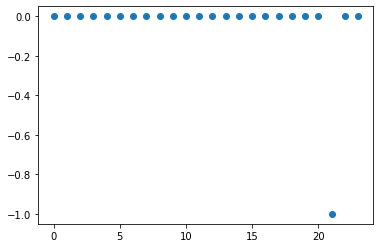

In [13]:
plt.plot(np.real((LF-LF1)/(2j*pi)),'o')

### Then the Chern number is obtained by summing over the differences shown in the figure above, which is $-1$. As a comparison, we can directly calculate the Chern number from LF, which is done by calling get_chern subroutine. The results are consistent as expected.

In [14]:
get_Chern(kx,ky,Ux,Uy)

-1.0000000000000002

### detailed examples for the two local gauge fields

In [15]:
# for plaquette 1
# show the gauge field values on the links

nx = 0
ny = 0

Ux_1 = Ux[nx*Ny+ny]
Uy_1 = Uy[nx*Ny+ny]
Ux_2 = Ux[nx*Ny+(ny+1)]
Uy_9 = Uy[(nx+1)*Ny+ny]
print(Ux_1,Uy_1,Ux_2,Uy_9)

(0.9978053217647059-0.06621585805554235j) (1+0j) (0.9999947561595762-0.003238464659293691j) (0.9998128344457947-0.01934673299205348j)


In [16]:
### obtain the two local gauge field by following Eq.(2) and Eq.(34) respectively
LF_1 = np.log( Ux_1 * Uy_9 * 1./Ux_2 * 1./Uy_1)
LF_1P = np.log(Ux_1) + np.log(Uy_9) - np.log(Ux_2) - np.log(Uy_1)
print(LF_1,LF_1P)

(1.0668549377257362e-16-0.08237381123102223j) (9.539962678335736e-17-0.08237381123102223j)


In [17]:
# for plaquette 21
# show the gauge field values on the links

nx = 2
ny = 5

Ux_21 = Ux[nx*Ny+ny]
Uy_21 = Uy[nx*Ny+ny]
Ux_22 = Ux[nx*Ny+(ny+1)]
Uy_6 = Uy[ny]
print(Ux_21,Uy_21,Ux_22,Uy_6)

(0.8569963006031104+0.515322559910376j) (0.6611161323737582-0.750283586062739j) (0.9947256490940544-0.10257135581833862j) (-1+0j)


In [18]:
### obtain the two local gauge field by following Eq.(2) and Eq.(34) respectively
LF_21 = np.log( Ux_21 * Uy_6 * 1./Ux_22 * 1./Uy_21)
LF_21P = np.log(Ux_21) + np.log(Uy_6) - np.log(Ux_22) - np.log(Uy_21)
print(LF_21,LF_21P)
print((LF_21-LF_21P)/(2j*pi))

(-3.6862873864507166e-16-1.648965667999456j) (-1.7000290064572712e-16+4.634219639180131j)
(-1.0000000000000002+3.16122839433657e-17j)
